### Distilling the Knowledge in a Neural Network

https://arxiv.org/pdf/1503.02531.pdf

In [7]:
from importlib import reload
import models
reload(models)
from __future__ import print_function
import keras
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
import numpy as np

In [8]:
batch_size = 1280
num_classes = 10
epochs = 60

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.1, 
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                            )

test_datagen = ImageDataGenerator()

train_datagen.fit(x_train)
test_datagen.fit(x_test)

In [9]:
model = dict()
hist = dict()
score = dict()
preds = dict()

In [12]:
reload(models)
model['teacher'] = models.TeacherModel(input_shape, num_classes)

model['teacher'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
model['teacher'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              18875392  
__________

In [13]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.teacher.hdf5', 
                               verbose=1, save_best_only=True)

hist['teacher'] = model['teacher'].fit(x_train, y_train, batch_size=batch_size,
          epochs=80, verbose=1, validation_data=(x_test, y_test), callbacks=[checkpointer])
score['teacher'] = model['teacher'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['teacher'][0])
print('Test accuracy:', score['teacher'][1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/80
60000/60000 [==============================] - 15s 256us/step - loss: 0.4598 - acc: 0.8509 - val_loss: 0.0677 - val_acc: 0.9772

Epoch 00001: val_loss improved from inf to 0.06767, saving model to saved_models/weights.best.teacher.hdf5
Epoch 2/80
60000/60000 [==============================] - 10s 161us/step - loss: 0.0759 - acc: 0.9774 - val_loss: 0.0389 - val_acc: 0.9863

Epoch 00002: val_loss improved from 0.06767 to 0.03893, saving model to saved_models/weights.best.teacher.hdf5
Epoch 3/80
60000/60000 [==============================] - 10s 160us/step - loss: 0.0493 - acc: 0.9847 - val_loss: 0.0350 - val_acc: 0.9877

Epoch 00003: val_loss improved from 0.03893 to 0.03505, saving model to saved_models/weights.best.teacher.hdf5
Epoch 4/80
60000/60000 [==============================] - 10s 162us/step - loss: 0.0372 - acc: 0.9891 - val_loss: 0.0312 - val_acc: 0.9903

Epoch 00004: val_loss improved from 0.03505 to 0.03125, savin

KeyboardInterrupt: 

In [14]:
model['teacher'].load_weights('saved_models/weights.best.teacher.hdf5')
score['teacher'] = model['teacher'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['teacher'][-1])*len(y_test))
print('Test loss:', score['teacher'][0])
print('Test accuracy:', score['teacher'][-1])
print('Test errors:', n_errors)

Test loss: 0.024305403147865216
Test accuracy: 0.9928
Test errors: 71


In [33]:
reload(models)
model['soft_teacher'] = models.SoftTeacherModel(input_shape, num_classes, l1=0.1, l2=0.05, b=3)

model['soft_teacher'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
model['soft_teacher'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              18875392  
__________

In [34]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.soft_teacher.hdf5', 
                               verbose=0, save_best_only=True, monitor='val_acc')

hist['soft_teacher'] = model['soft_teacher'].fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                                                           steps_per_epoch=len(x_train) // batch_size, 
                                                           epochs=100, verbose=1, 
                                                           validation_data=test_datagen.flow(x_test, y_test), 
                                                           validation_steps=len(x_train) // batch_size,
                                                           callbacks=[checkpointer])
score['soft_teacher'] = model['soft_teacher'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['soft_teacher'][0])
print('Test accuracy:', score['soft_teacher'][1])

Epoch 1/100
46/46 [==============================] - 25s 534ms/step - loss: 1.7503 - acc: 0.6004 - val_loss: 0.6740 - val_acc: 0.9667
Epoch 2/100
46/46 [==============================] - 22s 478ms/step - loss: 1.2259 - acc: 0.9332 - val_loss: 0.6350 - val_acc: 0.9857
Epoch 3/100
46/46 [==============================] - 23s 507ms/step - loss: 1.1806 - acc: 0.9609 - val_loss: 0.6522 - val_acc: 0.9810
Epoch 4/100
46/46 [==============================] - 24s 518ms/step - loss: 1.1613 - acc: 0.9689 - val_loss: 0.6769 - val_acc: 0.9851
Epoch 5/100
46/46 [==============================] - 25s 541ms/step - loss: 1.1495 - acc: 0.9744 - val_loss: 0.6750 - val_acc: 0.9891
Epoch 6/100
46/46 [==============================] - 22s 488ms/step - loss: 1.1413 - acc: 0.9778 - val_loss: 0.6827 - val_acc: 0.9885
Epoch 7/100
46/46 [==============================] - 24s 524ms/step - loss: 1.1342 - acc: 0.9804 - val_loss: 0.6896 - val_acc: 0.9952
Epoch 8/100
46/46 [==============================] - 23s 501ms

KeyboardInterrupt: 

In [35]:
model['soft_teacher'].load_weights('saved_models/weights.best.soft_teacher.hdf5')
score['soft_teacher'] = model['soft_teacher'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['soft_teacher'][-1])*len(y_test))
print('Test loss:', score['soft_teacher'][0])
print('Test accuracy:', score['soft_teacher'][-1])
print('Test errors:', n_errors)

Test loss: 0.7414493693351746
Test accuracy: 0.9943
Test errors: 57


In [5]:
reload(models)
model['student'] = models.StudentModel(input_shape, num_classes)

model['student'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
model['student'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_5 (Dense)              (None, 800)               640800    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                8010      
_________________________________________________________________
o2 (Activation)              (None, 10)                0         
Total params: 1,276,810
Trainable params: 1,276,810
Non-trainable params: 0
_________________________________________________________________


In [142]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student.hdf5', 
                               verbose=1, save_best_only=True)

hist['student'] = model['student'].fit(x_train, y_train, batch_size=batch_size,
          epochs=40, verbose=1, validation_data=(x_test, y_test), callbacks=[])
score['student'] = model['student'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['student'][0])
print('Test accuracy:', score['student'][1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 6s 101us/step - loss: 0.4455 - acc: 0.8778 - val_loss: 0.1931 - val_acc: 0.9443
Epoch 2/40
60000/60000 [==============================] - 1s 15us/step - loss: 0.1479 - acc: 0.9576 - val_loss: 0.1116 - val_acc: 0.9654
Epoch 3/40
60000/60000 [==============================] - 1s 15us/step - loss: 0.0919 - acc: 0.9735 - val_loss: 0.0934 - val_acc: 0.9707
Epoch 4/40
60000/60000 [==============================] - 1s 15us/step - loss: 0.0646 - acc: 0.9811 - val_loss: 0.0756 - val_acc: 0.9752
Epoch 5/40
60000/60000 [==============================] - 1s 15us/step - loss: 0.0468 - acc: 0.9857 - val_loss: 0.0735 - val_acc: 0.9767
Epoch 6/40
60000/60000 [==============================] - 1s 15us/step - loss: 0.0347 - acc: 0.9901 - val_loss: 0.0652 - val_acc: 0.9781
Epoch 7/40
60000/60000 [==============================] - 1s 15us/step - loss: 0.0249 - acc: 0.9933 - val_loss: 0.0629 - val_ac

In [10]:
model['student'].load_weights('saved_models/weights.best.student.hdf5')
score['student'] = model['student'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['student'][-1])*len(y_test))
print('Test loss:', score['student'][0])
print('Test accuracy:', score['student'][-1])
print('Test errors:', n_errors)

Test loss: 0.058851640967372804
Test accuracy: 0.9818
Test errors: 181


# Knowledge Distilation

In [36]:
kd_gt = dict()
T = 20
kd_gt['t_train'] = model['teacher'].T_model(T).predict(x_train, verbose=1, batch_size=batch_size)
kd_gt['t_test'] = model['teacher'].T_model(T).predict(x_test, verbose=1, batch_size=batch_size)
kd_gt['st_train'] = model['soft_teacher'].predict(x_train, verbose=1, batch_size=batch_size)
kd_gt['st_test'] = model['soft_teacher'].predict(x_test, verbose=1, batch_size=batch_size)

import numpy as np
np.linalg.norm(kd_gt['t_train'], axis=-1).mean(), np.linalg.norm(kd_gt['st_train'], axis=-1).mean()

10000/10000 [==============================] - 0s 48us/step


(0.35326484, 0.5726311)

In [28]:
# import numpy as np
# from keras.activations import softmax

# def softmax_with_temp(x):
#     Temp = 1.0
#     e_x = np.exp((x - x.max(axis=1, keepdims=True))/Temp)
#     out = e_x / e_x.sum(axis=1, keepdims=True)
#     return out

# def soft_with_T(T=1):
#     def swt(x):
#         return softmax(x/T)
#     return swt

In [12]:
''' KNOWLEDGE DISTILLATION WITH REGULAR TEACHER (TEMPERATURE SOFTMAX) '''
reload(models)
model['student_'] = models.StudentModel(input_shape, num_classes, T=T, in_class=True)
model['student_'].compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                          loss_weights=[1., 1. / (T**2)],
                          optimizer='Adam',
                          metrics=['acc'])

In [31]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student_.hdf5', 
                               verbose=1, save_best_only=True)

hist['student_'] = model['student_'].fit(x_train, [kd_gt['t_train'], y_train],
          batch_size=batch_size, epochs=200, verbose=1,
          validation_data=(x_test, [kd_gt['t_test'], y_test]), callbacks=[checkpointer])
score['student_'] = model['student_'].evaluate(x_test, [kd_gt['t_test'], y_test], verbose=0)
print('Test loss:', score['student_'][0])
print('Test accuracy:', score['student_'][-1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 31us/step - loss: 2.1679 - o1_loss: 2.1657 - o2_loss: 0.8971 - o1_acc: 0.7860 - o2_acc: 0.7859 - val_loss: 2.1178 - val_o1_loss: 2.1166 - val_o2_loss: 0.5106 - val_o1_acc: 0.9109 - val_o2_acc: 0.9087

Epoch 00001: val_loss improved from inf to 2.11784, saving model to saved_models/weights.best.student_.hdf5
Epoch 2/200
60000/60000 [==============================] - 1s 15us/step - loss: 2.1115 - o1_loss: 2.1105 - o2_loss: 0.3924 - o1_acc: 0.9276 - o2_acc: 0.9276 - val_loss: 2.1027 - val_o1_loss: 2.1020 - val_o2_loss: 0.2867 - val_o1_acc: 0.9468 - val_o2_acc: 0.9442

Epoch 00002: val_loss improved from 2.11784 to 2.10274, saving model to saved_models/weights.best.student_.hdf5
Epoch 3/200
60000/60000 [==============================] - 1s 16us/step - loss: 2.1020 - o1_loss: 2.1014 - o2_loss: 0.2301 - o1_acc: 0.9535 - o2_acc: 0.9534 - val_loss: 2.0970 - val_o1_loss: 2.0965 - val_

In [13]:
model['student_'].load_weights('saved_models/weights.best.student_.hdf5')
score['student_'] = model['student_'].evaluate(x_test, [kd_gt['t_test'], y_test], verbose=0)
n_errors = np.int((1-score['student_'][-1])*len(y_test))
print('Test loss:', score['student_'][0])
print('Test accuracy:', score['student_'][-1])
print('Test errors:', n_errors)

Test loss: 2.08525844039917
Test accuracy: 0.9879
Test errors: 121


In [14]:
''' SOFT TEACHER IN CLASS '''
reload(models)
from keras import callbacks

base_lr = 3e-3
decay = 0.99
optim = keras.optimizers.Adam(lr=base_lr)

model['student_st'] = models.StudentModel(input_shape, num_classes, T=1, in_class=True, l2=0.1, b=1.8)
model['student_st'].compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                          loss_weights=[0.1, 1.],
                          optimizer=optim,
                          metrics=['acc'])

In [35]:
def schedule(epoch):
    return base_lr * decay**(epoch)

#es = callbacks.EarlyStopping(monitor='val_o2_loss', mode='min', verbose=0, patience=30)
#mc = callbacks.ModelCheckpoint('best_student_st.h5', monitor='val_o2_acc', mode='max', verbose=0, save_best_only=True)
ls = callbacks.LearningRateScheduler(schedule)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student_st.hdf5', 
                               verbose=1, save_best_only=True)

hist['student_st'] = model['student_st'].fit(x_train, [kd_gt['st_train'], y_train],
          batch_size=batch_size,
          epochs=200,
          verbose=1,
          validation_data=(x_test, [kd_gt['st_test'], y_test]),
          callbacks=[ls, checkpointer],
            )
score['student_st'] = model['student_st'].evaluate(x_test, [kd_gt['st_test'], y_test], verbose=0)
print('Test loss:', score['student_st'][0])
print('Test accuracy:', score['student_st'][-1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 3s 45us/step - loss: 0.6732 - o1_loss: 2.3035 - o2_loss: 0.4428 - o1_acc: 0.8687 - o2_acc: 0.8682 - val_loss: 0.3854 - val_o1_loss: 2.1934 - val_o2_loss: 0.1660 - val_o1_acc: 0.9667 - val_o2_acc: 0.9640

Epoch 00001: val_loss improved from inf to 0.38538, saving model to saved_models/weights.best.student_st.hdf5
Epoch 2/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.3521 - o1_loss: 2.1580 - o2_loss: 0.1363 - o1_acc: 0.9730 - o2_acc: 0.9726 - val_loss: 0.3398 - val_o1_loss: 2.1484 - val_o2_loss: 0.1249 - val_o1_acc: 0.9779 - val_o2_acc: 0.9755

Epoch 00002: val_loss improved from 0.38538 to 0.33975, saving model to saved_models/weights.best.student_st.hdf5
Epoch 3/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.3117 - o1_loss: 2.1314 - o2_loss: 0.0985 - o1_acc: 0.9856 - o2_acc: 0.9851 - val_loss: 0.3240 - val_o1_loss: 2.1790 - 

In [15]:
model['student_st'].load_weights('saved_models/weights.best.student_st.hdf5')
score['student_st'] = model['student_st'].evaluate(x_test, [kd_gt['st_test'], y_test], verbose=0)
n_errors = np.int((1-score['student_st'][-1])*len(y_test))
print('Test loss:', score['student_st'][0])
print('Test accuracy:', score['student_st'][-1])
print('Test errors:', n_errors)

Test loss: 0.2814683969974518
Test accuracy: 0.9888
Test errors: 111


In [181]:
# x_small_train = x_train[np.argmax(y_train, axis=-1) != 3]
# y_small_train = y_train[np.argmax(y_train, axis=-1) != 3]
# x_small_train.shape

(53869, 28, 28, 1)

In [45]:
reload(models)
from keras import callbacks

base_l2 = 0.05
l2_decay = 0.98
l2_weight = K.variable(base_l2)

def changeAlpha(epoch,logs):
    #maybe use epoch+1, because it starts with 0
    K.set_value(l2_weight, base_l2 * l2_decay**epoch)

l2Changer = callbacks.LambdaCallback(on_epoch_end=changeAlpha)


base_lr = 2e-3
decay = 0.99
optim = keras.optimizers.Adam(lr=base_lr)

model['student_reg'] = models.SoftStudentModel(input_shape, num_classes, l1=0.1, l2=l2_weight, b=1)
model['student_reg'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optim,
              metrics=['accuracy'])

In [46]:
def schedule(epoch):
    return base_lr * decay**(epoch)

ls = callbacks.LearningRateScheduler(schedule)
#model['student_reg'].load_weights('saved_models/weights.best.student_reg.hdf5')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student_reg.hdf5', 
                               verbose=0, save_best_only=True)



# hist['student_reg'] = model['student_reg'].fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=100,
#           verbose=1,
#           validation_data=(x_test, y_test),
#           callbacks=[ls,checkpointer, l2Changer],
#             )

hist['student_reg'] = model['student_reg'].fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                                                           steps_per_epoch=len(x_train) // batch_size, 
                                                           epochs=100, verbose=1, 
                                                           validation_data=test_datagen.flow(x_test, y_test), 
                                                           validation_steps=len(x_test) // batch_size,
                                                           callbacks=[checkpointer, ls, l2Changer])
score['student_reg'] = model['student_reg'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['student_reg'][0])
print('Test accuracy:', score['student_reg'][-1])

Epoch 1/100
46/46 [==============================] - 26s 557ms/step - loss: 2.3520 - acc: 0.2578 - val_loss: 1.3872 - val_acc: 0.7321
Epoch 2/100
46/46 [==============================] - 24s 527ms/step - loss: 1.7344 - acc: 0.7073 - val_loss: 0.8933 - val_acc: 0.9420
Epoch 3/100
46/46 [==============================] - 23s 500ms/step - loss: 1.5492 - acc: 0.8606 - val_loss: 0.7433 - val_acc: 0.9688
Epoch 4/100
46/46 [==============================] - 23s 506ms/step - loss: 1.4731 - acc: 0.9072 - val_loss: 0.7082 - val_acc: 0.9821
Epoch 5/100
46/46 [==============================] - 24s 513ms/step - loss: 1.4287 - acc: 0.9290 - val_loss: 0.7149 - val_acc: 0.9598
Epoch 6/100
46/46 [==============================] - 24s 517ms/step - loss: 1.3962 - acc: 0.9411 - val_loss: 0.6403 - val_acc: 0.9821
Epoch 7/100
46/46 [==============================] - 24s 520ms/step - loss: 1.3672 - acc: 0.9488 - val_loss: 0.6499 - val_acc: 0.9911
Epoch 8/100
46/46 [==============================] - 24s 516ms

KeyboardInterrupt: 

In [47]:
model['student_reg'].load_weights('saved_models/weights.best.student_reg.hdf5')
score['student_reg'] = model['student_reg'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['student_reg'][-1])*len(y_test))
print('Test loss:', score['student_reg'][0])
print('Test accuracy:', score['student_reg'][-1])
print('Test errors:', n_errors)

Test loss: 0.08627716730833053
Test accuracy: 0.9933
Test errors: 67


# Analysis

In [38]:
#T = 20
preds['teacher_no_T'] = model['teacher'].predict(x_train, verbose=1, batch_size=batch_size)
preds['teacher'] = model['teacher'].T_model(T).predict(x_train, verbose=1, batch_size=batch_size)
preds['soft_teacher'] = model['soft_teacher'].predict(x_train, verbose=1, batch_size=batch_size)

import numpy as np
np.linalg.norm(preds['teacher'], axis=-1).mean(), np.linalg.norm(preds['soft_teacher'], axis=-1).mean()

60000/60000 [==============================] - 3s 49us/step


(0.35326484, 0.5726311)

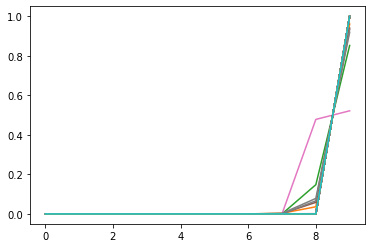

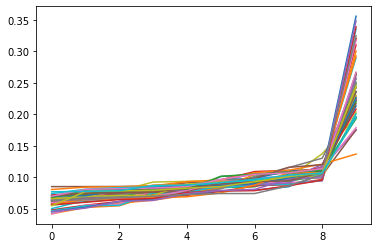

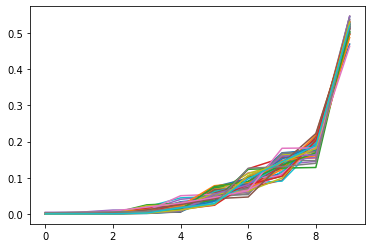

In [39]:
## Plot constrained softmax probabilities generated by the model

import matplotlib.pyplot as plt
ind = np.random.choice(len(preds['teacher_no_T']), 50)
plt.plot(np.sort(preds['teacher_no_T'])[ind].T)
plt.show()

ind = np.random.choice(len(preds['teacher']), 50)
plt.plot(np.sort(preds['teacher'])[ind].T)
plt.show()

ind = np.random.choice(len(preds['soft_teacher']), 50)
plt.plot(np.sort(preds['soft_teacher'])[ind].T)
plt.show()

In [28]:
from collections import Counter

pairs = [(x[-1], x[-2]) for x in np.argsort(preds['soft_teacher'])]
counts = Counter(pairs)
counts.most_common(20)

[((1, 8), 6546),
 ((0, 8), 5756),
 ((9, 8), 5610),
 ((3, 8), 5376),
 ((2, 8), 5208),
 ((6, 5), 4810),
 ((8, 3), 4232),
 ((7, 3), 4165),
 ((5, 8), 3847),
 ((4, 8), 3342),
 ((4, 9), 2444),
 ((7, 8), 1712),
 ((5, 3), 1171),
 ((6, 8), 968),
 ((8, 5), 711),
 ((8, 2), 572),
 ((2, 7), 407),
 ((3, 5), 401),
 ((5, 9), 380),
 ((2, 3), 336)]

/home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


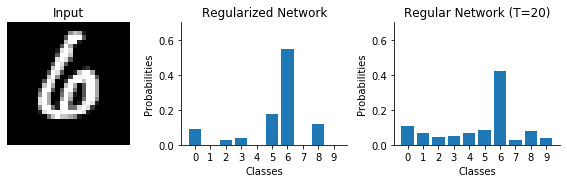

In [232]:
i = np.random.randint(len(x_train))
#i = 54270
fig, ax = plt.subplots(1, 3, figsize=(10,2.5), gridspec_kw={'width_ratios': [1.6, 2, 2], 'wspace': 0.3})
# plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2)
ax[0].imshow(x_train[i][:,:,0], cmap='gray', vmin=0, vmax=1)
ax[0].axis('off')
ax[0].set_title('Input')
ax[1].bar(np.linspace(0,9,10), preds['soft_teacher'][i])
ax[1].set_xticks(np.arange(0, 10, step=1))
ax[1].set_ylim(top=0.7)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Regularized Network')
ax[2].bar(np.linspace(0,9,10), preds['teacher'][i])
ax[2].set_xticks(np.arange(0, 10, step=1))
ax[2].set_ylim(top=0.7)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlabel('Classes')
ax[2].set_ylabel('Probabilities')
ax[2].set_title('Regular Network (T=20)')
#plt.savefig('figures/mnsit_{}.png'.format(i))
plt.show()

#plt.savefig('foo.png')

In [71]:
i

54270

In [ ]:
from collections import Counter

pairs = [(x[0], x[1]) for x in np.argsort(preds_st)]
counts = Counter(pairs)
counts.most_common(len(counts))

In [94]:
import tensorflow as tf
a = [[1, 10, 7, 9, 3, 66], [6, 4, 3, 2, 100, 0]]
b = tf.sort(a,axis=-1,direction='ASCENDING',name=None)
c = tf.keras.backend.eval(b)
c

array([[  1,   3,   7,   9,  10,  66],
       [  0,   2,   3,   4,   6, 100]], dtype=int32)